In [1]:
import os
import random
import cv2
import numpy as np
from collections import defaultdict

from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

# from nms import non_max_supression_slow as nms
from nms import non_max_supression_with_scores as nms

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import chainer
from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline 

with open('./clsid_to_name.txt', 'r') as f:
    classes = list(map(lambda l: l.split('\'')[1].split(',')[0].strip(' ,\''), f.readlines()))

In [2]:
##############
# PARAMETERS #
##############

# DIRECTORY
DIR = '/data/unagi0/ilsvrc2017/ILSVRC/'

# GPU (-1 if performing on CPU)
GPU = 0

# IMAGE SELECTION PARAMETERS
RANDOM_SEED = 200
NUMBER_OF_IMAGES = 3

# SELECTIVE-SEARCH PARAMETERS
SCALE = 250
SIGMA = 0.9
MIN_SIZE = 50
MIN_REGION = 2000
MAX_RATIO = 2

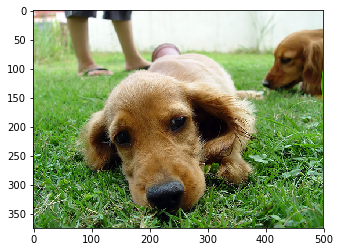

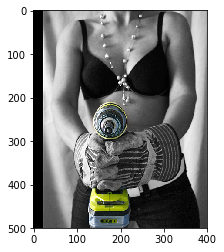

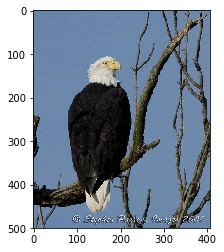

In [3]:
# Get image filenames from val.txt image set
with open(os.path.join(DIR, 'ImageSets/DET/val.txt')) as f:
    dataset = list(map(lambda f: f.strip().split()[0], f.readlines()))

# Sample random images from dataset
random.seed(RANDOM_SEED)
sample = random.sample(range(len(dataset)), NUMBER_OF_IMAGES)
image_paths = [os.path.join(DIR, 'Data/DET/val', dataset[i] + '.JPEG') for i in sample]

# Load and Display images
imgs = list()
for img_file in image_paths:
    img = mpimg.imread(img_file)
    imgs.append({"original": img})
    plt.figure()
    plt.imshow(img)

105
92
55
CPU times: user 6.94 s, sys: 225 ms, total: 7.17 s
Wall time: 7.17 s


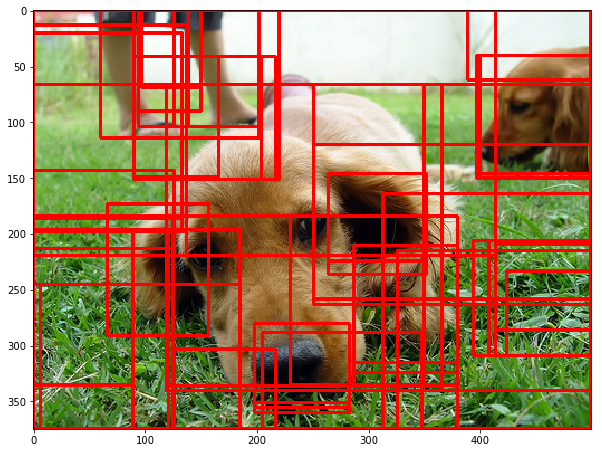

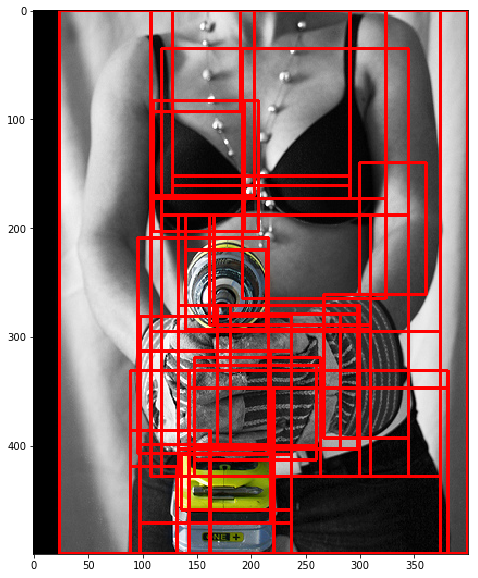

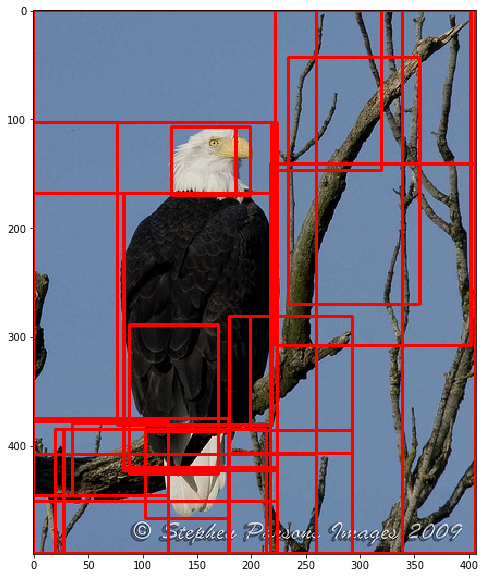

In [4]:
%%time
# Perform selective search on each image
for img in imgs:
    img_lbl, regions = selective_search(img["original"], scale=SCALE, sigma=SIGMA, min_size=MIN_SIZE)
    img["cropped_regions"] = []
    img["bbox"] = []
    img["class"] = []
    img["conf"] = []
    
    img_copy = img["original"].copy() # image copy for drawing regions and displaying
    
    for region in regions:
        x, y, w, h = region['rect']
        if (region['size'] < MIN_REGION) or (w / h > MAX_RATIO) or (h / w > MAX_RATIO):
            continue
        
        img["bbox"].append(np.array([x,x+w,y,y+h]))
        # axis order and data type changed in preparation for input into CNN model
        img["cropped_regions"].append(np.moveaxis(img["original"][y:y+h,x:x+w,:],2,0).astype(np.float32))
        
        # for displaying regions (copies are made so as to not leave red borders in original image)
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), 0xFF3333, thickness=2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(img_copy)
    print(len(img["cropped_regions"]))   

In [5]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    model.to_gpu()

CPU times: user 5.3 s, sys: 1.94 s, total: 7.24 s
Wall time: 4.28 s


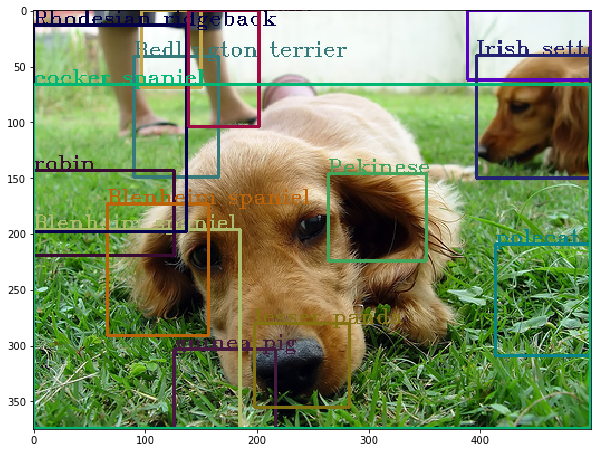

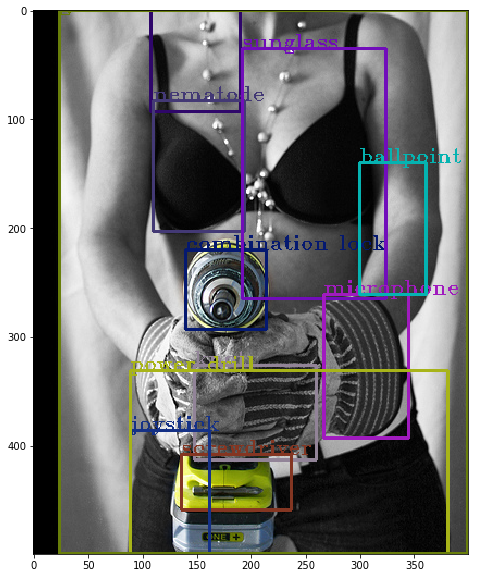

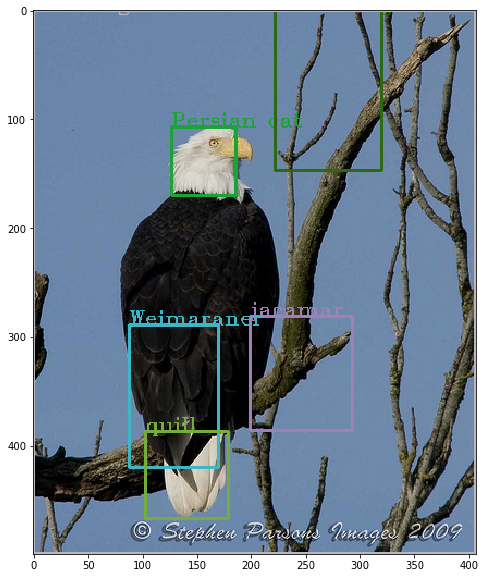

In [8]:
%%time
for img in imgs:
    img["prob"] = model.predict(img["cropped_regions"])
    for prob in img["prob"]:
        img["class"].append(np.argmax(prob))
        img["conf"].append(np.max(prob))
    img["picks"] = nms(img["bbox"], img["conf"], 0.3)
    
    img_copy = img["original"].copy()
    for pick in img["picks"]:
        x1, x2, y1, y2 = img["bbox"][pick]
        cls = img["class"][pick]
        rand_color = (random.randint(0,200), random.randint(0,200), random.randint(0,200))
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), rand_color, thickness=2)
        cv2.putText(img_copy, classes[cls], (x1,y1), cv2.FONT_HERSHEY_TRIPLEX, 0.6, rand_color)
    plt.figure(figsize=(10,10))
    plt.imshow(img_copy)

In [10]:
len(img["conf"])

1